In [524]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson, mode
from typing import List, Tuple
import scipy
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
from pprint import pprint
import math
from scipy.integrate import solve_ivp

In [525]:
sample_rate = 25000
step_size = 1 / sample_rate
signal_length = 3

## Parent Neuron Class

In [526]:
class Neuron:
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda):
        self.v_rest = v_rest
        self.sample_rate = sample_rate
        self.h = 1 / sample_rate
        self.thr = thr
        self.tf = tf
        self.t_ref = t_ref
        self.lmbda = lmbda
        self.length_v = int(tf * sample_rate)
        self.t_ref_i = int(t_ref * sample_rate)
        self.v_values = np.zeros(self.length_v)

    def f(self, t, v):
        I_0 = 0.01
        R = 10**4
        tau = 0.02
        dv_dt = (- (v-self.v_rest) + R * I_0)/tau
        return dv_dt

    def solve_ode(self, y0, t0):
        sol = solve_ivp(self.f, [t0, self.tf], [y0], method='RK45', t_eval=np.linspace(t0, self.tf, 1000))
        return sol.y[0], sol.t
        
    def identify_neuron_spikes(self, neuron_signal) -> List[int]:
        # the positions of the spikes in the signal
        return [i for i, value in enumerate(neuron_signal) if value >= max(neuron_signal)]

    def simulate(self):
        pass

    def plot_signal(self):
        fig, ax = plt.subplots(figsize=(12, 3))
        neuron_signal = self.v_values
        time = np.arange(len(neuron_signal)) / self.sample_rate
        ax.plot(time, neuron_signal, c="k", lw=0.5)
        ax.axhline(y=self.thr, c="grey", linewidth=0.5, ls=":", zorder=0, label=f"threshold {self.thr}")
        fig.legend()
        ax.set_title('Signal Emitted by Neuron')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (mV)')
        ax.set_xlim(0, np.max(time))
        plt.tight_layout()
        plt.show()

## LIF Neuron with Euler Integrator

In [527]:
class EulerLIF(Neuron):
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda):
        super().__init__(v_rest, sample_rate, thr, tf, t_ref, lmbda)
        
    def solve_ode(self, y0, t0):
        # uses the euler ODE method
        y_values = []
        t = t0
        y = y0
        while y < self.thr:
            t += self.h
            y += self.h * self.f(t, y)
            y_values.append(y)
        return y_values, t
    
    def simulate(self):
        i = 0
        t = 0
        step = 0
        while i < self.length_v:
            rnd_thr = random.random()
            prob = poisson.cdf(step, mu=self.lmbda)
            step += 1
            if prob < rnd_thr:
                rnd_time = int(self.t_ref_i * 4 * random.random())
                if i + rnd_time < self.length_v:
                    self.v_values[i:i+rnd_time] = self.v_rest
                    i = i + rnd_time
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
            else:
                v_t, t = self.solve_ode(self.v_rest, t)
                new_i = int(round(t / self.h))
                if new_i + self.t_ref_i + 2 <= self.length_v:
                    self.v_values[i:new_i] = v_t
                    i = new_i + 1
                    self.v_values[i] = self.v_values[i-1] + 80
                    i += 1
                    self.v_values[i] = self.v_rest - 10
                    i += 1
                    new_i = i + self.t_ref_i
                    self.v_values[i:new_i] = self.v_rest
                    i = new_i
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
        return self.v_values

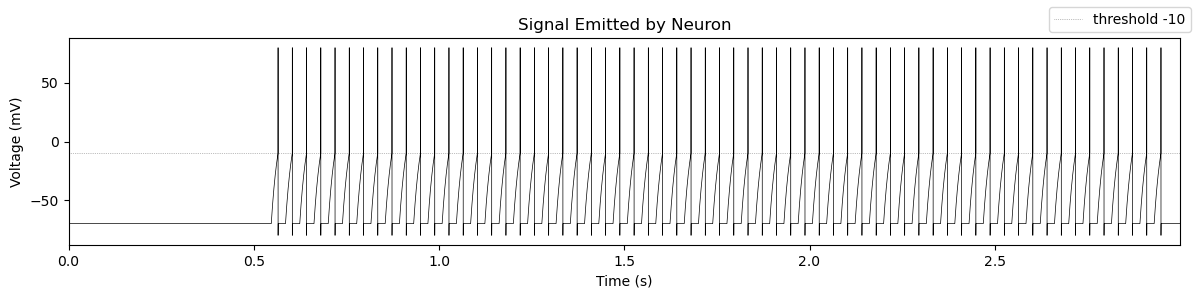

In [528]:
euler_lif_neuron = EulerLIF(v_rest=-70, sample_rate=sample_rate, thr=-10, tf=signal_length, t_ref=0.02, lmbda=14)
euler_lif_neuron.simulate()
euler_lif_neuron.plot_signal()

## LIF Neuron with Scipy Integrator

In [529]:
from scipy.interpolate import interp1d

class RKLIF(Neuron):
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda):
        super().__init__(v_rest, sample_rate, thr, tf, t_ref, lmbda)

    def threshold_event(self, t, v):
        return v[0] - self.thr

    threshold_event.terminal = True
    threshold_event.direction = 1

    def solve_ode(self, y0, t0):
        sol = solve_ivp(self.f, [t0, self.tf], [y0], method='RK45', t_eval=np.linspace(t0, self.tf, self.length_v),
                        events=self.threshold_event)
        return sol.y[0], sol.t

    def simulate(self):
        i = 0
        t = 0
        step = 0
        while i < self.length_v:
            rnd_thr = random.random()
            prob = poisson.cdf(step, mu=self.lmbda)
            step += 1
            if prob < rnd_thr:
                rnd_time = int(self.t_ref_i * 4 * random.random())
                if i + rnd_time < self.length_v:
                    self.v_values[i:i+rnd_time] = self.v_rest
                    i = i + rnd_time
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
            else:
                v_t, t = self.solve_ode(self.v_rest, t)
                new_i = int(round(t[-1] / self.h))
                if new_i + self.t_ref_i + 2 <= self.length_v:
                    # Interpolate the solution to the original time steps
                    interp_func = interp1d(t, v_t, kind='linear', fill_value='extrapolate')
                    v_t_interp = interp_func(np.linspace(t[0], t[-1], new_i - i))

                    self.v_values[i:new_i] = v_t_interp
                    i = new_i + 1
                    self.v_values[i] = self.v_values[i-1] + 80
                    i += 1
                    self.v_values[i] = self.v_rest - 10
                    i += 1
                    new_i = i + self.t_ref_i
                    self.v_values[i:new_i] = self.v_rest
                    i = new_i
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
        return self.v_values

rklif_neuron = EulerLIF(v_rest=-70, sample_rate=sample_rate, thr=-10, tf=signal_length, t_ref=0.02, lmbda=14)
rklif_neuron.simulate()
rklif_neuron.plot_signal()

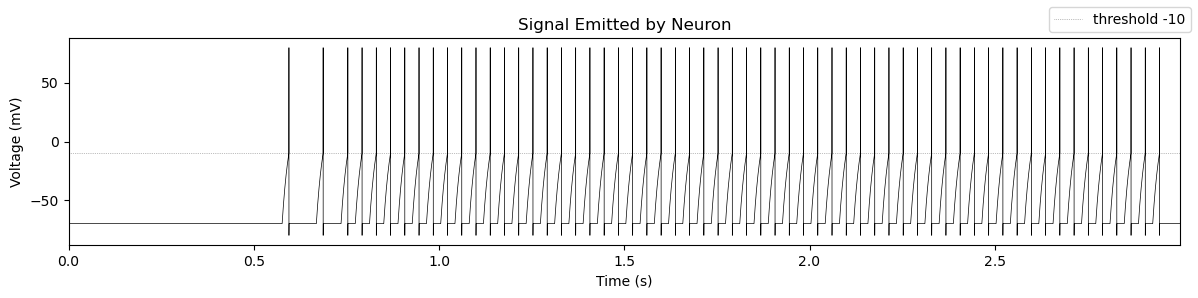

In [530]:
lif_neuron = RKLIF(v_rest=-70, sample_rate=sample_rate, thr=-10, tf=signal_length, t_ref=0.02, lmbda=14)
lif_neuron.simulate()
lif_neuron.plot_signal()

## Bursting Neuron

`neither of bursting methods currently working`

To model the bursting behaviour of a neuron we can use an adapted LIF model with an adaptation current.

Each time a spike is generated, the adaptation current is increased by a given amount, decaying over time. Essentially, this increases the firing threshold overtime making it more difficult for the neuron to produce spikes. After a spike burst, the current is high meaning the neuron has a lower probability of firing, as the current then decays the neuron is more likely to enter another bursting state.

In [531]:
class BurstingNeuron(Neuron):
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda, a=0.02, b=0.2, c=-65, d=8):
        super().__init__(v_rest, sample_rate, thr, tf, t_ref, lmbda)
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.u_values = np.zeros(self.length_v)

    def f(self, t, y):
        """Izhikevich neuron model"""
        v, u = y
        I = 5  # constant input current
        dv_dt = 0.04*v**2 + 5*v + 140 - u + I
        du_dt = self.a * (self.b*v - u)
        return [dv_dt, du_dt]

    def reset(self, t, y):
        v, u = y
        return v - self.thr

    reset.terminal = True
    reset.direction = 1

    def solve_ode(self, y0, t0):
        sol = solve_ivp(
            self.f, 
            [t0, self.tf], 
            y0, 
            method='RK45', 
            t_eval=np.linspace(t0, self.tf, self.length_v),
            events=self.reset
        )
        return sol.y[0], sol.t

    def simulate(self):
        i = 0
        t = 0
        step = 0
        y = [self.v_rest, self.v_rest*self.b]
        while i < self.length_v:
            v_t, t = self.solve_ode(y, t)
            new_i = int(round(t[-1] / self.h))
            if new_i + self.t_ref_i + 2 <= self.length_v:
                self.v_values[i:new_i] = v_t
                i = new_i + 1
                self.v_values[i] = self.c
                self.u_values[i] += self.d
                i += 1
                self.v_values[i] = self.v_rest
                i += 1
                new_i = i + self.t_ref_i
                self.v_values[i:new_i] = self.v_rest
                i = new_i
                t = i * self.h
                y = [self.v_values[i], self.u_values[i]]
            else:
                self.v_values[i:self.length_v] = self.v_rest
                break
        return self.v_values

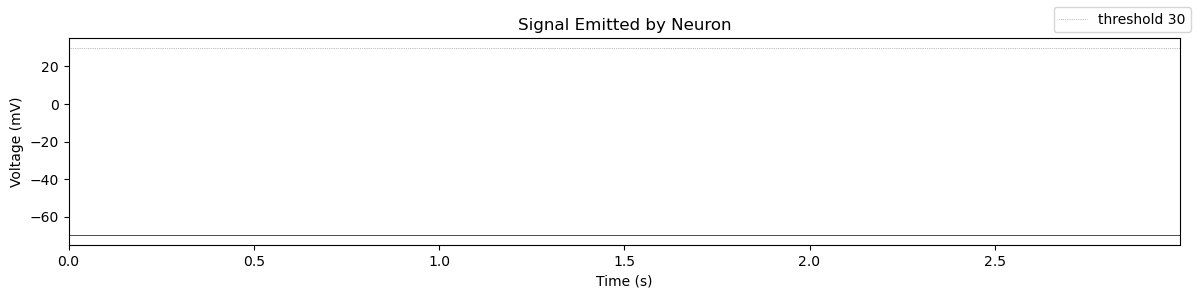

In [532]:
bursting_neuron = BurstingNeuron(v_rest=-70, sample_rate=sample_rate, thr=30, tf=signal_length, t_ref=0.02, lmbda=14)
bursting_neuron.simulate()
bursting_neuron.plot_signal()

In [533]:
class AdaptingLIFNeuron(Neuron):
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda, a=0.02, b=0.2, c=-65, d=8, tau_adapt=0.2, adapt_step=2):
        super().__init__(v_rest, sample_rate, thr, tf, t_ref, lmbda)
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.tau_adapt = tau_adapt
        self.adapt_step = adapt_step
        self.adapt_values = np.zeros(self.length_v)

    def f(self, t, y):
        v, u, w = y
        I = 10  # constant input current
        dv_dt = (0.04 * v**2) + (5 * v) + 140 - u - w + I
        du_dt = self.a * (self.b*v - u)
        dw_dt = -w / self.tau_adapt  # w represents the adaptation current
        return [dv_dt, du_dt, dw_dt]
    
    def solve_ode(self, y0, t0):
        sol = solve_ivp(
            self.f, [t0, self.tf], 
            y0, 
            method='RK45', 
            t_eval=np.linspace(t0, self.tf, self.length_v),
            events=self.reset
        )
        return sol.y[0], sol.y[2], sol.t

    def reset(self, t, y):
        v, u, w = y
        return self.thr - v  # when v goes above threshold, it triggers


    def after_spike(self, y):
        v, u, w = y
        return [self.c, u + self.d, w + self.adapt_step]  # increment the adaptation current after a spike
    
    def simulate(self):
        i = 0
        t = 0
        step = 0
        y = [self.v_rest, self.v_rest*self.b, 0]  # w is initially 0
        while i < self.length_v:
            v_t, w_t, t = self.solve_ode(y, t)
            new_i = int(round(t[-1] / self.h))
            if new_i + self.t_ref_i + 2 <= self.length_v:
                self.v_values[i:new_i] = v_t
                self.adapt_values[i:new_i] = w_t  # store adaptation current
                i = new_i + 1
                y = self.after_spike(y)
                self.v_values[i] = y[0]
                self.adapt_values[i] = y[2]
                i += 1
                self.v_values[i] = self.v_rest
                i += 1
                new_i = i + self.t_ref_i
                self.v_values[i:new_i] = self.v_rest
                i = new_i
                t = i * self.h
                y = [self.v_values[i], self.u_values[i], self.adapt_values[i]]
            else:
                self.v_values[i:self.length_v] = self.v_rest
                self.adapt_values[i:self.length_v] = y[2]  # store adaptation current
                break
        return self.v_values, self.adapt_values

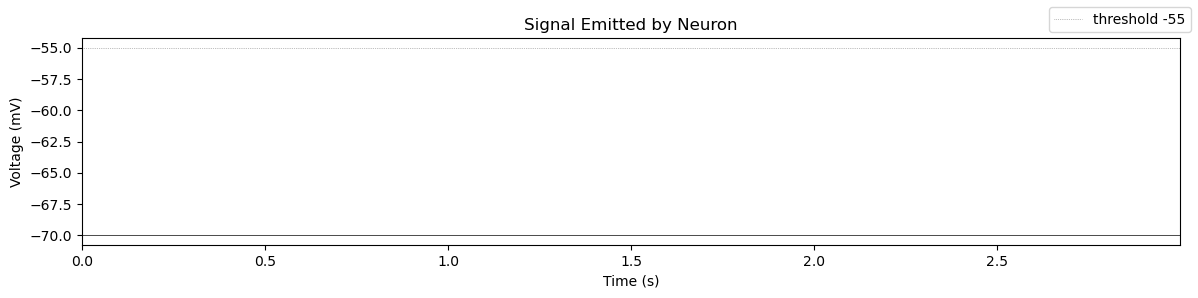

In [534]:
bursting_neuron = AdaptingLIFNeuron(v_rest=-70, sample_rate=1000, thr=-55, tf=3, t_ref=0.02, lmbda=14)
bursting_neuron.simulate()
bursting_neuron.plot_signal()

In [535]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate a set of parameters to test
# parameters = {
#     "a": [0.02, 0.03, 0.04],
#     "b": [0.2, 0.25, 0.3],
#     "c": [-65, -70, -75],
#     "d": [6, 8, 10],
#     "tau_adapt": [0.15, 0.2, 0.25],
#     "adapt_step": [1, 2, 3]
# }

# # Generate all combinations of parameters
# from itertools import product
# parameter_combinations = list(product(*parameters.values()))

# # Define some constants for the simulation
# v_rest = -65
# sample_rate = 1000
# thr = -50
# tf = 1.0
# t_ref = 0.005
# lmbda = 1

# for i, parameter_values in enumerate(parameter_combinations):
#     # Create the neuron
#     neuron = AdaptingLIFNeuron(v_rest, sample_rate, thr, tf, t_ref, lmbda, *parameter_values)
    
#     # Simulate the neuron
#     v_values, adapt_values = neuron.simulate()

#     # Plot the voltage trace
#     plt.figure(figsize=(10, 5))
#     plt.plot(np.linspace(0, tf, len(v_values)), v_values)
#     plt.title(f"Neuron {i+1} with parameters {dict(zip(parameters.keys(), parameter_values))}")
#     plt.xlabel('Time (s)')
#     plt.ylabel('Membrane potential (mV)')
#     plt.show()
